# Flightops - Data Acquisition, Loading and Pre-processing

## Extracting Data from BTS
Flight data for 2018–2019 is sourced from the BTS TranStats repository using an automated downloader script:
- `download_bts_ontime.py` fetches monthly On-Time Performance files and extracts them into the project directory.
- Run this command from the repo root to download the necessary files: *python download_bts_ontime.py*

## Load, and Clean Data

Data cleaning is one of the most critical (and usually most tedious) part of data analysis. But the effort is always worth it because, as the old saying goes, **garbage in, garbage out!**

environment: conda activate datasci311

### Set stable root directory for relative paths in VSCode

VS Code + Jupyter has notoriously unstable CWDs because it is flexible in where it runs notebooks from (e.g. the workspace root, a previously cached directory, a kernel opened *before* the repo was opened...). It's great that VSC has this flexibility, but it presents a weakness when making repos available in CI/GitHub. I've removed the ambiguity by controlling the CWD to make relative paths stable.

In [1]:
from pathlib import Path
import pandas as pd

# Establish repo root (notebooks live one level down)
REPO_ROOT = Path.cwd().parent

DATA_DIR = REPO_ROOT / "data/raw/csv"


### Load and Concatenate Files

After extracting the required files from BTS, we'll load and combine them into one dataframe.

In [2]:
files = sorted(DATA_DIR.glob("*.csv"))
print(f"Found {len(files)} CSV files.") # used for visibility when debugging cwd issues

# Specify columns to load to save memory, reducing columns loaded from 110 to 30 and dataframe memory usage from ~24.8 GB to ~11.1 GB
usecols = [
    # Date / identifiers
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "FlightDate",
    "Reporting_Airline",
    "IATA_CODE_Reporting_Airline",
    "Flight_Number_Reporting_Airline",
    "Tail_Number",

    # Origin / destination
    "Origin",
    "OriginCityName",
    "OriginState",
    "Dest",
    "DestCityName",
    "DestState",

    # Scheduled vs actual times
    "CRSDepTime",
    "CRSArrTime",
    "DepTime",
    "ArrTime",

    # Delay metrics
    "DepDelay",
    "DepDelayMinutes",
    "DepDel15",
    "ArrDelay",
    "ArrDelayMinutes",
    "ArrDel15",

    # Status flags
    "Cancelled",
    "Diverted",
    "CancellationCode",

    # Distance / throughput
    "Distance",
    "Flights",
]

# Adding a dtype map to reduce memory usage further
dtypes = {
    "Year": "int16",
    "Month": "int8",
    "DayofMonth": "int8",
    "DayOfWeek": "int8",
    "Reporting_Airline": "category",
    "IATA_CODE_Reporting_Airline": "category",
    "Tail_Number": "category",
    "Flight_Number_Reporting_Airline": "int32",
    "Origin": "category",
    "OriginCityName": "category",
    "OriginState": "category",
    "Dest": "category",
    "DestCityName": "category",
    "DestState": "category",
    "CRSDepTime": "int32",
    "CRSArrTime": "int32",
    "DepTime": "float32",
    "ArrTime": "float32",
    "DepDelay": "float32",
    "DepDelayMinutes": "float32",
    "DepDel15": "Int8",
    "ArrDelay": "float32",
    "ArrDelayMinutes": "float32",
    "ArrDel15": "Int8",
    "Cancelled": "Int8",
    "Diverted": "Int8",
    "CancellationCode": "category",
    "Distance": "float32",
    "Flights": "Int8",
}

dfs = [pd.read_csv(f, low_memory=False, usecols=usecols, dtype=dtypes) for f in files]

flights = pd.concat(dfs, ignore_index=True)


Found 24 CSV files.


In [3]:
len(flights), flights.memory_usage(deep=True).sum() / (1024**3)


(14628232, np.float64(8.14171683229506))

#### Find TranStats terminology at:
[BTS Table Info](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr&V0s1_b0yB=D)

### Data Cleaning

BTS column names are in all caps, with mixed formatting, so we'll strip out white space and special characters and replace spaces and hyphens with underscores for standard Python-friendly formatting.

Additionally, these BTS tables report on cancelled and diverted flights. This data will distort KPIs like average delay and on-time rates because they do not have meaningful arrival delay values. Therefore, we will filter them out.


In [4]:
# Standardize column names

flights.columns = (
    flights.columns.str.strip()  # Remove leading/trailing whitespace
        .str.lower()  # Lowercase all characters
        .str.replace(" ", "_")  # Replace spaces with underscores
)

In [5]:
# Fill missing flags as 0/1, removing any NaNs that may interfere with filtering

flag_cols = ["cancelled", "diverted", "depdel15", "arrdel15", "flights"]
for c in flag_cols:
    flights[c] = flights[c].fillna(0).astype("int8")


In [6]:
# Filter Cancelled/Diverted Flights

flights_clean = flights[
    (flights['cancelled'] == 0) &
    (flights['diverted'] == 0)
].copy()

print(f"Rows before cleaning: {len(flights)}")
print(f"Rows after cleaning: {len(flights_clean)}")

Rows before cleaning: 14628232
Rows after cleaning: 14340046


<mark>personal note</mark>

.copy() uses a lot of RAM. Flights currently uses ~8G memory, which pushes to 16G when executing above code. If more issues arise due to memory overhead (other apps open and using RAM), then use this code to filter with a mask, selected only needed columns, before you copy:

mask = (flights["cancelled"] == 0) & (flights["diverted"] == 0)
flights_clean = flights.loc[mask].copy()

print(f"Rows before cleaning: {len(flights):,}")
print(f"Rows after cleaning:  {len(flights_clean):,}")


In [7]:
# Delete flights dataframe to free up memory (and prevent crashes during modeling)
del flights
import gc
gc.collect()

0

In [9]:
flights_clean


,year,month,dayofmonth,dayofweek,flightdate,reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,origin,...,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,cancelled,cancellationcode,diverted,flights,distance
0,2018,1,17,3,2018-01-17,B6,B6,N516JB,375,PHL,...,958,1004.0,6.0,6.0,0,0,NaN,0,1,992.0
1,2018,1,17,3,2018-01-17,B6,B6,N565JB,376,FLL,...,1411,1426.0,15.0,15.0,1,0,NaN,0,1,992.0
2,2018,1,17,3,2018-01-17,B6,B6,N507JB,380,LGB,...,1419,1419.0,0.0,0.0,0,0,NaN,0,1,231.0
5,2018,1,17,3,2018-01-17,B6,B6,N258JB,389,BOS,...,1102,1126.0,24.0,24.0,1,0,NaN,0,1,399.0
8,2018,1,17,3,2018-01-17,B6,B6,N594JB,392,TPA,...,2225,2305.0,40.0,40.0,1,0,NaN,0,1,1185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14628227,2019,9,26,4,2019-09-26,OH,OH,N607NN,5709,VPS,...,2144,2122.0,-22.0,0.0,0,0,NaN,0,1,460.0
14628228,2019,9,27,5,2019-09-27,OH,OH,N590NN,5709,VPS,...,2144,2131.0,-13.0,0.0,0,0,NaN,0,1,460.0
14628229,2019,9,28,6,2019-09-28,OH,OH,N608NN,5709,VPS,...,2144,2133.0,-11.0,0.0,0,0,NaN,0,1,460.0
14628230,2019,9,29,7,2019-09-29,OH,OH,N591NN,5709,VPS,...,2144,2128.0,-16.0,0.0,0,0,NaN,0,1,460.0


### Time-based features for modeling

In [8]:
# Scheduled Departure Hour
flights_clean['dep_hour'] = (flights_clean['crsdeptime'].floordiv(100).astype('int8'))

# Weekend Flag
flights_clean['is_weekend'] = flights_clean['dayofweek'].isin([6, 7]).astype('int8')

# Route feature (control size of feature by using categories to save memory)
flights_clean['route'] = (flights_clean['origin'].astype(str) + "-" + flights_clean['dest'].astype(str)).astype('category')

In [9]:
# Sanity check feature creation
flights_clean[['arrdel15', 'dep_hour', 'is_weekend', 'route', 'distance']].head()

,arrdel15,dep_hour,is_weekend,route,distance
0,0,7,0,PHL-FLL,992.0
1,1,11,0,FLL-PHL,992.0
2,0,13,0,LGB-LAS,231.0
5,1,9,0,BOS-DCA,399.0
8,1,19,0,TPA-BOS,1185.0


In [10]:
# memory check
flights_clean.memory_usage(deep=True).sum() / (1024**3)

np.float64(8.070323660038412)

### Exploratory Data Analysis (EDA)

#### Dataset sanity check first:

In [11]:
flights_clean.shape

(14340046, 33)

In [ ]:
# check for distribution, range of hours, distance scale
flights_clean[['arrdel15', 'dep_hour', 'is_weekend', 'route', 'distance']].describe()

,arrdel15,dep_hour,is_weekend,distance
count,1.434005e+07,1.434005e+07,1.434005e+07,1.434005e+07
mean,1.911722e-01,1.301689e+01,2.646068e-01,8.025521e+02
std,3.932244e-01,4.901964e+00,4.411236e-01,5.962351e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01
25%,0.000000e+00,9.000000e+00,0.000000e+00,3.670000e+02
50%,0.000000e+00,1.300000e+01,0.000000e+00,6.390000e+02
75%,0.000000e+00,1.700000e+01,1.000000e+00,1.035000e+03
max,1.000000e+00,2.300000e+01,1.000000e+00,5.095000e+03


#### Class balance: how many flights are late?

In [14]:
late_rate = flights_clean['arrdel15'].mean()
late_rate

np.float64(0.19117219010315586)

In [16]:
flights_clean["arrdel15"].value_counts(normalize=True)

arrdel15
0    0.808828
1    0.191172
Name: proportion, dtype: float64

19.1% of flights were late, or nearly 1 in 5--normal for airline data. Use as baseline difficulty

#### Delay rate by departure hour (strongest predictor)

In [17]:
hourly_delay = (
    flights_clean
        .groupby('dep_hour', observed=True)['arrdel15']
        .mean()
        .reset_index()
        .sort_values(by='dep_hour')
)

hourly_delay.head()

,dep_hour,arrdel15
0,0,0.171765
1,1,0.169344
2,2,0.238233
3,3,0.240095
4,4,0.204902


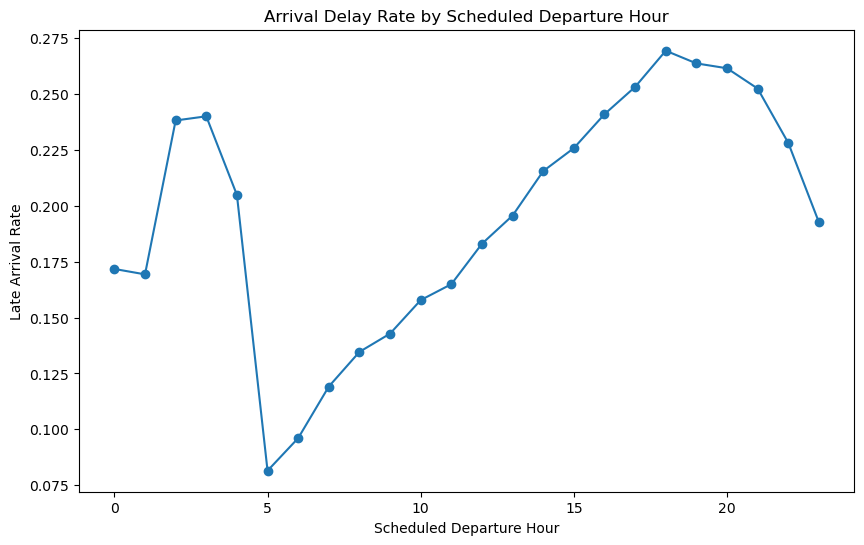

In [18]:
# plot hourly delay rate
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_delay['dep_hour'], hourly_delay['arrdel15'], marker='o')
plt.title('Arrival Delay Rate by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Late Arrival Rate')
plt.show()

**Observations**
1. morning flights have lowest delay rate
2. delay risks climbs throughout the day

#### Weekend v Weekday effect

In [19]:
weekend_delay = (
    flights_clean
        .groupby('is_weekend', observed=True)['arrdel15']
        .mean()
        .reset_index()
)

weekend_delay

,is_weekend,arrdel15
0,0,0.196241
1,1,0.177086


In [21]:
# label 0/1 for clarity
weekend_delay['day_type'] = weekend_delay['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
weekend_delay[['day_type', 'arrdel15']]

,day_type,arrdel15
0,Weekday,0.196241
1,Weekend,0.177086


**Observations**
1. lower delay rates on the weekends
2. feature useful, but not as strong as time of day

##### Carrier-level delay performance (top 10 by volume)

In [ ]:
# top 10 carriers by flight count
top_carriers = (
    flights_clean["iata_code_reporting_airline"]
        .value_counts()
        .head(10)
        .index
)

# calculate average arrival delay rate for top carriers
carrier_delay = (
    flights_clean[flights_clean["iata_code_reporting_airline"].isin(top_carriers)]
    .groupby("iata_code_reporting_airline", observed=True)["arrdel15"]
    .mean()
    .sort_values()
    .reset_index()
)

carrier_delay

,iata_code_reporting_airline,arrdel15
0,DL,0.141423
1,AS,0.175857
2,WN,0.185569
3,OO,0.187821
4,YX,0.189507
5,UA,0.204098
6,OH,0.204386
7,MQ,0.205209
8,AA,0.206107
9,B6,0.263244


#### Route-level delay (top 10 busiest routes)

In [ ]:
# top 10 routes by flight count
top_routes = (
    flights_clean["route"]
        .value_counts()
        .head(10)
        .index
)

top_routes

CategoricalIndex(['SFO-LAX', 'LGA-ORD', 'LAX-SFO', 'ORD-LGA', 'LAX-JFK',
                  'JFK-LAX', 'LAX-LAS', 'LAS-LAX', 'HNL-OGG', 'OGG-HNL'],
                 categories=['ABE-ATL', 'ABE-BNA', 'ABE-CLT', 'ABE-DTW', ..., 'YNG-PIE', 'YNG-SFB', 'YUM-DFW', 'YUM-PHX'], ordered=False, dtype='category', name='route')

In [ ]:
# calculate average arrival delay rate for top routes
route_delay = (
    flights_clean[flights_clean["route"].isin(top_routes)]
    .groupby("route", observed=True)["arrdel15"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

route_delay

,route,arrdel15
0,ORD-LGA,0.306061
1,LGA-ORD,0.272611
2,LAX-SFO,0.248160
3,SFO-LAX,0.237232
4,LAX-JFK,0.189505
5,LAS-LAX,0.183980
6,JFK-LAX,0.182364
7,LAX-LAS,0.173164
8,OGG-HNL,0.091415
9,HNL-OGG,0.060129


**Observations:**
1. routes that systematically underperform: Chicago→La Guardia ↺, Los Angeles→San Francisco ↺
2. are route-level features useful in model?

#### Distance v delay
sanity check--long flights have buffer to absorb delays, so short flights should show high volatility

In [42]:
distance_bins = pd.cut(flights_clean['distance'], bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000])

distance_delay = (
    flights_clean
        .groupby(distance_bins, observed=True)['arrdel15']
        .mean()
        .reset_index()
)

distance_delay

,distance,arrdel15
0,"(0, 500]",0.182359
1,"(500, 1000]",0.193730
2,"(1000, 1500]",0.203205
3,"(1500, 2000]",0.196030
4,"(2000, 2500]",0.194620
5,"(2500, 3000]",0.208241
6,"(3000, 4000]",0.157802
7,"(4000, 5000]",0.173123


In [ ]:
distance_delay = (
    flights_clean
        .groupby(distance_bins, observed=True)['arrdelay']
        .mean()
        .reset_index()
)

distance_delay

,distance,arrdelay
0,"(0, 500]",5.355517
1,"(500, 1000]",5.682519
2,"(1000, 1500]",5.540549
3,"(1500, 2000]",3.825565
4,"(2000, 2500]",2.355150
5,"(2500, 3000]",3.495347
6,"(3000, 4000]",1.403966
7,"(4000, 5000]",-0.197101


**Observation**
I can see the following breakdown in delay rates:
- short-haul (0 - 500): ~18.2%
- mid-haul (500-1500): ~19-20%
- long-haul (1500-3000): ~20%
- very long-haul (3000+): ~16.2%
long-haul flights have built-in schedule buffers, priority handling, reduced connection dependencies that reduce delayed arrival probability. The lower rate is expected. Short flights must handle faster turn around, congested airspace, and gate delays that have greater affect on crossing the 15 minute threshold.

In [46]:
# volatility for short vs long hauls actually shows up in the stdev of delay rates
distance_delay_stdev = (
    flights_clean
        .groupby(distance_bins, observed=True)['arrdelay']
        .std()
        .reset_index()
)

distance_delay_stdev

,distance,arrdelay
0,"(0, 500]",48.387997
1,"(500, 1000]",49.251621
2,"(1000, 1500]",50.300522
3,"(1500, 2000]",46.259834
4,"(2000, 2500]",49.228642
5,"(2500, 3000]",56.008659
6,"(3000, 4000]",69.566414
7,"(4000, 5000]",64.549355


In [47]:
distance_delay_iqr = (
    flights_clean
        .groupby(distance_bins, observed=True)['arrdelay']
        .quantile([0.25, 0.75])
        .unstack()
)

distance_delay_iqr["iqr"] = distance_delay_iqr[0.75] - distance_delay_iqr[0.25]
distance_delay_iqr.reset_index()

,distance,0.25,0.75,iqr
0,"(0, 500]",-14.0,6.0,20.0
1,"(500, 1000]",-15.0,8.0,23.0
2,"(1000, 1500]",-16.0,9.0,25.0
3,"(1500, 2000]",-16.0,9.0,25.0
4,"(2000, 2500]",-19.0,8.0,27.0
5,"(2500, 3000]",-20.0,10.0,30.0
6,"(3000, 4000]",-20.0,5.0,25.0
7,"(4000, 5000]",-22.0,6.0,28.0


#### Memory cleanup
...or, next time upgrade to the bigger memory package! 🧘🏻‍♀️

In [50]:
del hourly_delay, weekend_delay, carrier_delay, route_delay, distance_delay, distance_delay_iqr, distance_delay_stdev
import gc
gc.collect()


324